# Exploration11: 폐렴 진단기 성능 개선

## Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 데이터를 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X_ray 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해 보세요.
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져옵니다.  
train과 val에 있는 데이터를 모은 이후 train:val의 비를 80:20으로 분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다.
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다.
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


train 데이터 안에 있는 정상 이미지 수와 폐렴 이미지 수 측정

In [5]:
# 정상 이미지와 폐렴 이미지는 파일 경로로 구분할 수 있습니다.
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [6]:
# 파일 경로를 통해 정상, 폐렴 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


정상보다 폐렴 이미지 수가 3배 가량 많습니다. 학습을 진행할 CNN 모델은 class별 balance가 좋을 수록 뛰어난 성능을 발휘합니다.  
따라서 클래스 불균형 현상은 차후에 조정할 것입니다. 반면 test와 val 데이터셋은 평가를 위해 사용되며 학습과 관련이 없으므로 문제가 없습니다.

tf.data는 tensorflow에서 학습시킬 때 배치처리 작업을 보다 효율적으로 할 수 있도록 도와줍니다.
tf.data 인스턴스를 만들어줍니다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# Train, Validation 데이터셋의 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


라벨 데이터가 없기 때문에 따로 만들어 주어야 합니다. 파일 경로의 'NORMAL', 'PNEUMONIA'를 이용해 라벨 데이터를 만들어주는 함수를 만듭니다.

In [9]:
# 파일 경로의 끝에서 두 번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다.
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA" # 폐렴이면 양성(True), 노말이면 음성(False)

이미지 사이즈를 통일시키고 줄여주는 decode_img함수와 process_path 함수를 만듭니다.
process_path 함수에서 decode_img 함수를 이용해 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경하고, get_label을 이용해 라벨 값을 가져옵니다.

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) #이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train, validation 데이터 셋을 만듭니다. num_parallel_calls 파라미터레서 set-up 초기화한 뒤 AUTOTUNE을 이용하면 더욱 빠르게 데이터를 처리해 줍니다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지, 라벨 확인
for image, label in train_ds.take(1):
    print("Image shape:" ,image.numpy().shape)
    print("Label: ", label.numpy())

Image shape: (180, 180, 3)
Label:  False


In [13]:
# 테스트 데이터셋도 똑같이 만들어줌
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


prepare_for_training() 함수는 학습 데이터를 효율적으로 데이터 변환시켜줍니다.
* shuffle()은 고정 크기 버퍼를 유지한 상태로 균일하게 무작위 추출을 수행합니다.
* repeat()은 여러 번 데이터셋을 불러오는 경우 자동으로 데이터를 맞춰줍니다.
* prefetch()는 GPU에서 학습이 이루어지는 동안 다음 CPU가 다음 데이터를 준비할 수 있게 만들어줍니다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Step 3. 데이터 시각화

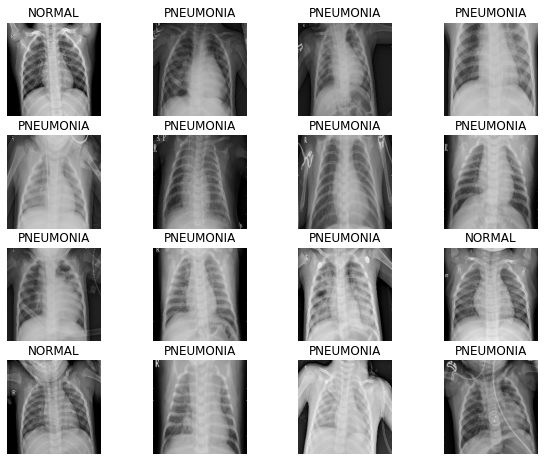

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5, math.ceil(BATCH_SIZE/5), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")
        
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Step 4. CNN 모델링

conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결합니다.  
또한 Normalization과 Dropout이라는 두 가지 refularization은 일반적으로 동시에 사용되지 않는데, 두 방법을 같이 쓰는 것을 옹호하는 의견이 있기도 합니다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

Normal 이미지에 비해서 Pneumonia 데이터가 많은, 즉 imbalance한 경우 학습 효과가 좋지 않을 수 있습니다.  
Weight balancing은 이런 문제를 해결하는 테크닉 중 하나로 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다.  
코드에서 weight_for_0은 Normal 이미지에 사용할 weight를, weight_for_1은 Pneumonia에 사용할 weight를 세팅합니다.  
이 weight들은 normal과 pneumonia 전체 데이터 건수에 반비례하도록 설정됩니다.

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Step 6. 모델 훈련
모델은 위에서 만들었던 모델 함수인 build_model()을 모델에 선언합니다.  
또한 이미지 라벨이 두 개 밖에 없기 때문에 binary_cross entropy를 loss로 사용하며 optimizer로 'adam'을 사용합니다.  
성과 측정을 위한 metrics로 'accuracy', 'precision', 'recall'을 사용합니다.

In [20]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 55s 140ms/step - loss: 0.6283 - accuracy: 0.6733 - precision: 0.8985 - recall: 0.6348 - val_loss: 0.5902 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 34s 132ms/step - loss: 0.2432 - accuracy: 0.9029 - precision: 0.9734 - recall: 0.8947 - val_loss: 0.8369 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 34s 131ms/step - loss: 0.1928 - accuracy: 0.9249 - precision: 0.9779 - recall: 0.9207 - val_loss: 0.1629 - val_accuracy: 0.9365 - val_precision: 0.9902 - val_recall: 0.9233
Epoch 4/25
261/261 [==============================] - 34s 130ms/step - loss: 0.1897 - accuracy: 0.9316 - precision: 0.9805 - recall: 0.9256 - val_loss: 0.3848 - val_accuracy: 0.8606 - val_precision: 1.0000 - val_recall: 0.8100
Epoch 5/25
261/261 [==============================] - 34s 132ms/step - loss: 0.1440 - accura

## Step 7. 결과 확인과 시각화

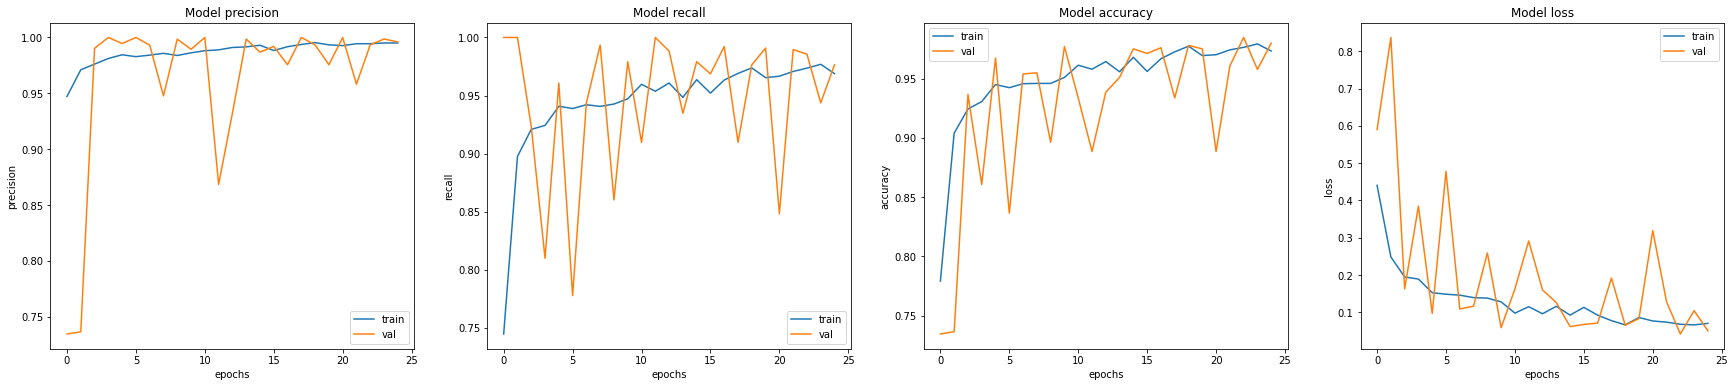

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(30, 6))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy}.\nPrecision: {precision},\mRecall: {recall}')

39/39 [==============================] - 3s 77ms/step - loss: 1.0377 - accuracy: 0.8045 - precision: 0.7638 - recall: 0.9949
Loss: 1.0376969575881958,
Accuracy: 0.8044871687889099.
Precision: 0.7637795209884644,\mRecall: 0.9948717951774597
